# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result

from networkx import Graph
from networkx.algorithms.approximation import min_weighted_dominating_set

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

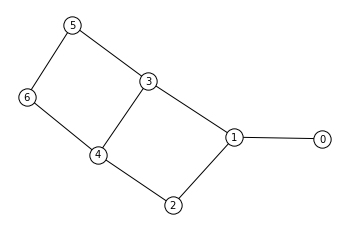

{'tag': 'simple',
 'total_vertices': 7,
 'total_edges': 8,
 'max_edges': 6,
 'adjacency': [[0, 1], [1, 2], [1, 3], [4, 6], [3, 4], [2, 4], [6, 5], [3, 5]],
 'adjacency_hash': 'b6d92c0344635fc0536b863cf1e50418'}

In [31]:
# Define Adjacency matrix
tag = "simple"
graph = {(0, 1), (1, 2)}
graph = {(0, 1), (1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 6), (6, 5)}
penalty = 8

directed = False
qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True)

q_min = np.array(list(qubo.values())).min()

gt.get_plot(graph, directed=directed)
plt.show()
graph_params = graph_summary(tag, graph)
graph_params

In [32]:
def QUBO_to_Ising(Q):
    q = np.diagonal(Q);
    QD = np.copy(Q);
    for i in range(len(QD)):
        QD[i,i] = 0.;
    QQ = np.copy(QD + np.transpose(QD))
    J = np.triu(QQ)/4.
    uno = np.ones(len(QQ));
    h = q/2 + np.dot(QQ, uno)/4;
    g = np.dot(uno, np.dot(QD, uno))/4. + np.dot(q, uno)/2.
    return (J, h, g)

In [38]:
J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
print(f"max(J) = {maxJ}")
print(f"max(h) = {maxh}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges")
fact = max([maxJ, maxh/2]) * 1.2
qubo = qubo / fact

J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
print("Rescaled")
print(f"max(J) = {maxJ}")
print(f"max(h) = {maxh}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges")

max(J) = 0.5673758865248228
max(h) = 1.6666666666666667
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges
Rescaled
max(J) = 0.5673758865248228
max(h) = 1.6666666666666667
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges


In [39]:
#classical_search(qubo)

In [40]:
# DWave settings
dwave_config = {
    "annealing_time": 200,  # integer microseconds [1, 2000]
    "answer_mode": "histogram",
    "auto_scale": False,
    "num_reads": 1000,  # raw will dump out all results
    "num_spin_reversal_transforms": 0,  # ask Travis what this is
    "readout_thermalization": 0, # default 0
    "programming_thermalization": 1000, # default 1000
}
solver = "DW_2000Q_5"

experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, qubo=qubo)
experiment_params

{'machine': 'DW_2000Q_5',
 'settings': {'annealing_time': 200,
  'answer_mode': 'histogram',
  'auto_scale': False,
  'num_reads': 1000,
  'num_spin_reversal_transforms': 0,
  'readout_thermalization': 0,
  'programming_thermalization': 1000},
 'settings_hash': '8cc0f4b11ab6d51b8785c6685355efee',
 'p': 8,
 'qubo': [[-1.0638297872340428,
   2.2695035460992914,
   1.1347517730496457,
   1.1347517730496457,
   0.0,
   0.0,
   0.0,
   -1.1347517730496457,
   -1.1347517730496457,
   -2.2695035460992914,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   -2.198581560283688,
   2.2695035460992914,
   2.2695035460992914,
   2.2695035460992914,
   1.1347517730496457,
   0.0,
   -1.1347517730496457,
   -1.1347517730496457,
   -2.2695035460992914,
   -1.1347517730496457,
   -2.2695035460992914,
   -1.1347517730496457,
   -2.2695035460992914,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   -1.6312056737588654,
   2.2695035460992914,
   2

In [41]:
# Solve on DWave and push to database
sampler = DWaveSampler(solver=solver)
embed = EmbeddingComposite(sampler)
qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
result = embed.sample_qubo(qubo_dict, **dwave_config)
raw = result.to_pandas_dataframe().sort_values("energy", ascending=True)
print(raw)
data_params = data_summary(raw, graph_params, experiment_params, fact)
#insert_result(graph_params, experiment_params, data_params)
data_params

     0  1  2  3  4  5  6  7  8  9  ...  13  14  15  16  17  18  19  \
114  1  1  0  1  0  0  1  1  0  1  ...   0   1   0   1   0   0   0   
113  1  0  1  1  1  0  0  0  0  1  ...   0   0   1   0   0   0   0   
69   1  1  1  1  0  0  1  1  1  1  ...   0   0   1   1   0   0   0   
102  0  1  0  1  0  1  0  0  1  0  ...   0   0   0   1   0   0   0   
99   0  1  0  1  1  0  1  0  1  0  ...   0   0   1   1   0   1   0   
..  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..   
4    0  0  0  0  0  1  1  0  0  0  ...   1   1   0   0   1   0   0   
0    0  0  0  0  0  1  1  0  0  0  ...   1   1   0   0   1   0   0   
24   1  0  0  0  0  1  1  1  1  0  ...   1   1   0   0   1   0   0   
52   1  0  0  0  0  1  1  0  0  0  ...   1   1   0   0   1   0   0   
109  0  0  0  0  0  1  0  0  0  0  ...   1   1   0   0   1   0   0   

     chain_break_fraction    energy  num_occurrences  
114                  0.00 -3.687943                1  
113                  0.00 -3.687943              

{'spin_config': array([[1, 1, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]], dtype=int8),
 'energy': array([52.31205674, 52.31205674, 52.38297872, 52.80851064, 52.87943262,
        52.87943262, 52.95035461, 52.95035461, 52.95035461, 52.95035461,
        52.95035461, 53.37588652, 53.44680851, 53.44680851, 53.5177305 ,
        53.5177305 , 53.5177305 , 53.5177305 , 53.5177305 , 53.5177305 ,
        53.58865248, 53.58865248, 53.58865248, 53.58865248, 53.58865248,
        53.58865248, 53.58865248, 53.58865248, 53.58865248, 53.58865248,
        54.0141844 , 54.0141844 , 54.0141844 , 54.0141844 , 54.08510638,
        54.08510638, 54.08510638, 54.08510638, 54.08510638, 54.08510638,
        54.08510638, 54.08510638, 54.15602837, 54.15602837, 54.15602837,
        54.15602837, 54.15602837, 54.15602837, 54.15602837, 54.15602837,
        54.15602837,

In [8]:
sampler._properties["extended_j_range"]

[-2.0, 1.0]

In [9]:
from qlpdb.data.models import Data as data_Data


In [10]:
data_Data.objects.to_dataframe()

,id,last_modified,user,tag,experiment,measurement,spin_config,energy,constraint_satisfaction
0,1,2020-02-19 18:02:14.310086+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",0,"[0, 0, 1, 0, 0, 0, 1]",0.0,False
1,2,2020-02-19 18:10:14.611037+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",1,"[0, 1, 1, 0, 0, 0, 1]",0.0,False
2,3,2020-02-19 18:10:14.644381+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",2,"[0, 0, 1, 0, 0, 0, 1]",0.0,False
3,4,2020-02-19 18:10:21.856004+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",3,"[1, 1, 0, 1, 0, 0, 0]",0.0,False
4,5,2020-02-19 18:10:21.888778+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",4,"[1, 1, 0, 1, 0, 0, 0]",0.0,False
5,6,2020-02-19 18:10:42.337369+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",5,"[1, 0, 1, 0, 1, 0, 0]",-1.0,True
6,7,2020-02-19 18:10:42.362146+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",6,"[1, 0, 1, 0, 1, 0, 0]",-1.0,True


In [11]:
a = """
153 153 3.9166666666666665
155 155 0.875
156 156 0.4166666666666665
157 157 1.5
280 280 2.5
281 281 2.4166666666666665
282 282 2.875
283 283 2.375
284 284 1.5
285 285 1.5
286 286 5.5
287 287 0.375
153 156 -4.0
155 156 2.0
153 157 -1.0
155 157 -1.0
153 281 -4.0
155 283 -4.0
280 284 0.0
281 284 -1.0
282 284 -1.0
283 284 0.0
280 285 2.0
281 285 -1.0
282 285 -1.0
283 285 -1.0
280 286 -4.0
281 286 -2.0
282 286 -1.0
283 286 -2.0
280 287 -1.0
281 287 2.0
282 287 -4.0
283 287 1.0
"""
# no manual scale, auto True
a1 = """
1424 1424 -2.5
1425 1425 2.333333333333333
1426 1426 6.0
1430 1430 0.33333333333333304
1552 1552 3.5
1553 1553 2.333333333333333
1554 1554 7.5
1555 1555 1.0
1556 1556 6.0
1557 1557 16.0
1558 1558 9.0
1559 1559 -8.5
1424 1430 4.0
1425 1430 -4.0
1426 1430 -4.0
1424 1552 -4.0
1425 1553 -4.0
1426 1554 -4.0
1552 1556 -4.0
1553 1556 0.0
1554 1556 -4.0
1555 1556 0.0
1552 1557 -8.0
1553 1557 -8.0
1554 1557 -8.0
1555 1557 8.0
1552 1558 -4.0
1553 1558 -4.0
1554 1558 -2.0
1555 1558 -4.0
1552 1559 8.0
1553 1559 8.0
1554 1559 -4.0
1555 1559 -2.0
"""
# no manual scale, auto True
a2 = """
145 145 6.0
146 146 6.0
147 147 2.333333333333333
150 150 4.333333333333333
272 272 3.5
273 273 4.0
274 274 4.5
275 275 -1.666666666666667
276 276 6.0
277 277 -5.5
278 278 16.0
279 279 -2.5
145 150 -4.0
146 150 -4.0
147 150 -4.0
145 273 -4.0
146 274 -4.0
147 275 -4.0
272 276 -4.0
273 276 0.0
274 276 -4.0
275 276 0.0
272 277 4.0
273 277 -4.0
274 277 -4.0
275 277 8.0
272 278 -8.0
273 278 8.0
274 278 -8.0
275 278 -8.0
272 279 -4.0
273 279 -4.0
274 279 4.0
275 279 4.0"""
# manual rescale no auto
a3 = """
1552 1552 0.875
1553 1553 3.583333333333333
1554 1554 1.5
1559 1559 1.5833333333333333
1680 1680 2.375
1681 1681 2.083333333333333
1682 1682 3.375
1683 1683 1.75
1684 1684 4.0
1685 1685 1.5
1686 1686 -0.625
1687 1687 3.75
1552 1559 1.0
1553 1559 -4.0
1554 1559 -1.0
1552 1680 -4.0
1553 1681 -4.0
1554 1682 -1.0
1680 1684 -2.0
1681 1684 -2.0
1682 1684 -2.0
1683 1684 2.0
1680 1685 -1.0
1681 1685 0.0
1682 1685 -1.0
1683 1685 0.0
1680 1686 2.0
1681 1686 2.0
1682 1686 -4.0
1683 1686 -0.5
1680 1687 -1.0
1681 1687 -1.0
1682 1687 -0.5
1683 1687 -4.0
"""
# manual rescale no auto
a4 = """
1123 1123 1.3333333333333335
1124 1124 4.333333333333334
1126 1126 2.0
1128 1128 2.375
1129 1129 1.375
1130 1130 1.5
1131 1131 2.625
1132 1132 3.833333333333333
1133 1133 0.125
1134 1134 6.0
1135 1135 0.875
1257 1257 1.875
1259 1259 2.75
1260 1260 2.75
1123 1124 -4.0
1123 1126 2.0
1124 1132 -4.0
1128 1132 -1.0
1129 1132 -1.0
1130 1132 0.0
1131 1132 -1.0
1128 1133 1.0
1129 1133 2.0
1130 1133 -1.0
1131 1133 -4.0
1126 1134 -4.0
1128 1134 -2.0
1129 1134 -2.0
1130 1134 0.0
1131 1134 -2.0
1128 1135 -4.0
1129 1135 1.0
1130 1135 -1.0
1131 1135 1.0
1129 1257 -4.0
1131 1259 -1.0
1257 1260 -1.0
1259 1260 -4.0
"""
# manual rescale with auto
a5 = """
18 18 0.625
19 19 4.083333333333333
20 20 0.5833333333333333
23 23 1.5
144 144 2.875
145 145 2.5
146 146 2.125
147 147 2.583333333333333
148 148 0.375
149 149 1.5
150 150 1.5
151 151 5.5
18 20 2.0
19 20 -4.0
18 23 -1.0
19 23 -1.0
18 146 -4.0
19 147 -4.0
144 148 -4.0
145 148 -1.0
146 148 2.0
147 148 1.0
144 149 -1.0
145 149 2.0
146 149 -1.0
147 149 -1.0
144 150 -1.0
145 150 0.0
146 150 -1.0
147 150 0.0
144 151 -1.0
145 151 -4.0
146 151 -2.0
147 151 -2.0"""

In [12]:
def sucks(a):
    mapdict = dict()
    for l in a.split('\n')[1:-1]:
        li = l.split(' ')
        mapdict[(int(li[0]), int(li[1]))] = float(li[2])
    setkey = {key[0] for key in mapdict}
    setkey.union({key[1] for key in mapdict})
    newdict = dict()
    for idx, key in enumerate(setkey):
        newdict[key] = idx
    arrmap2 = np.zeros((len(setkey), len(setkey)))
    for key, val in mapdict.items():
        #if newdict[key[0]] < newdict[key[1]]:
        #    k1 = newdict[key[0]]
        #    k2 = newdict[key[1]]
        #else:
        #    k1 = newdict[key[1]]
        #    k2 = newdict[key[0]]
        k1 = newdict[key[0]]
        k2 = newdict[key[1]]
        arrmap2[k1, k2] += val
    return arrmap2

max(J) = 2.0
max(h) = 4.0
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges
max(J) = 2.0
max(h) = 4.0
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges
max(J) = 1.0
max(h) = 1.0
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges
max(J) = 1.0
max(h) = 0.5
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges


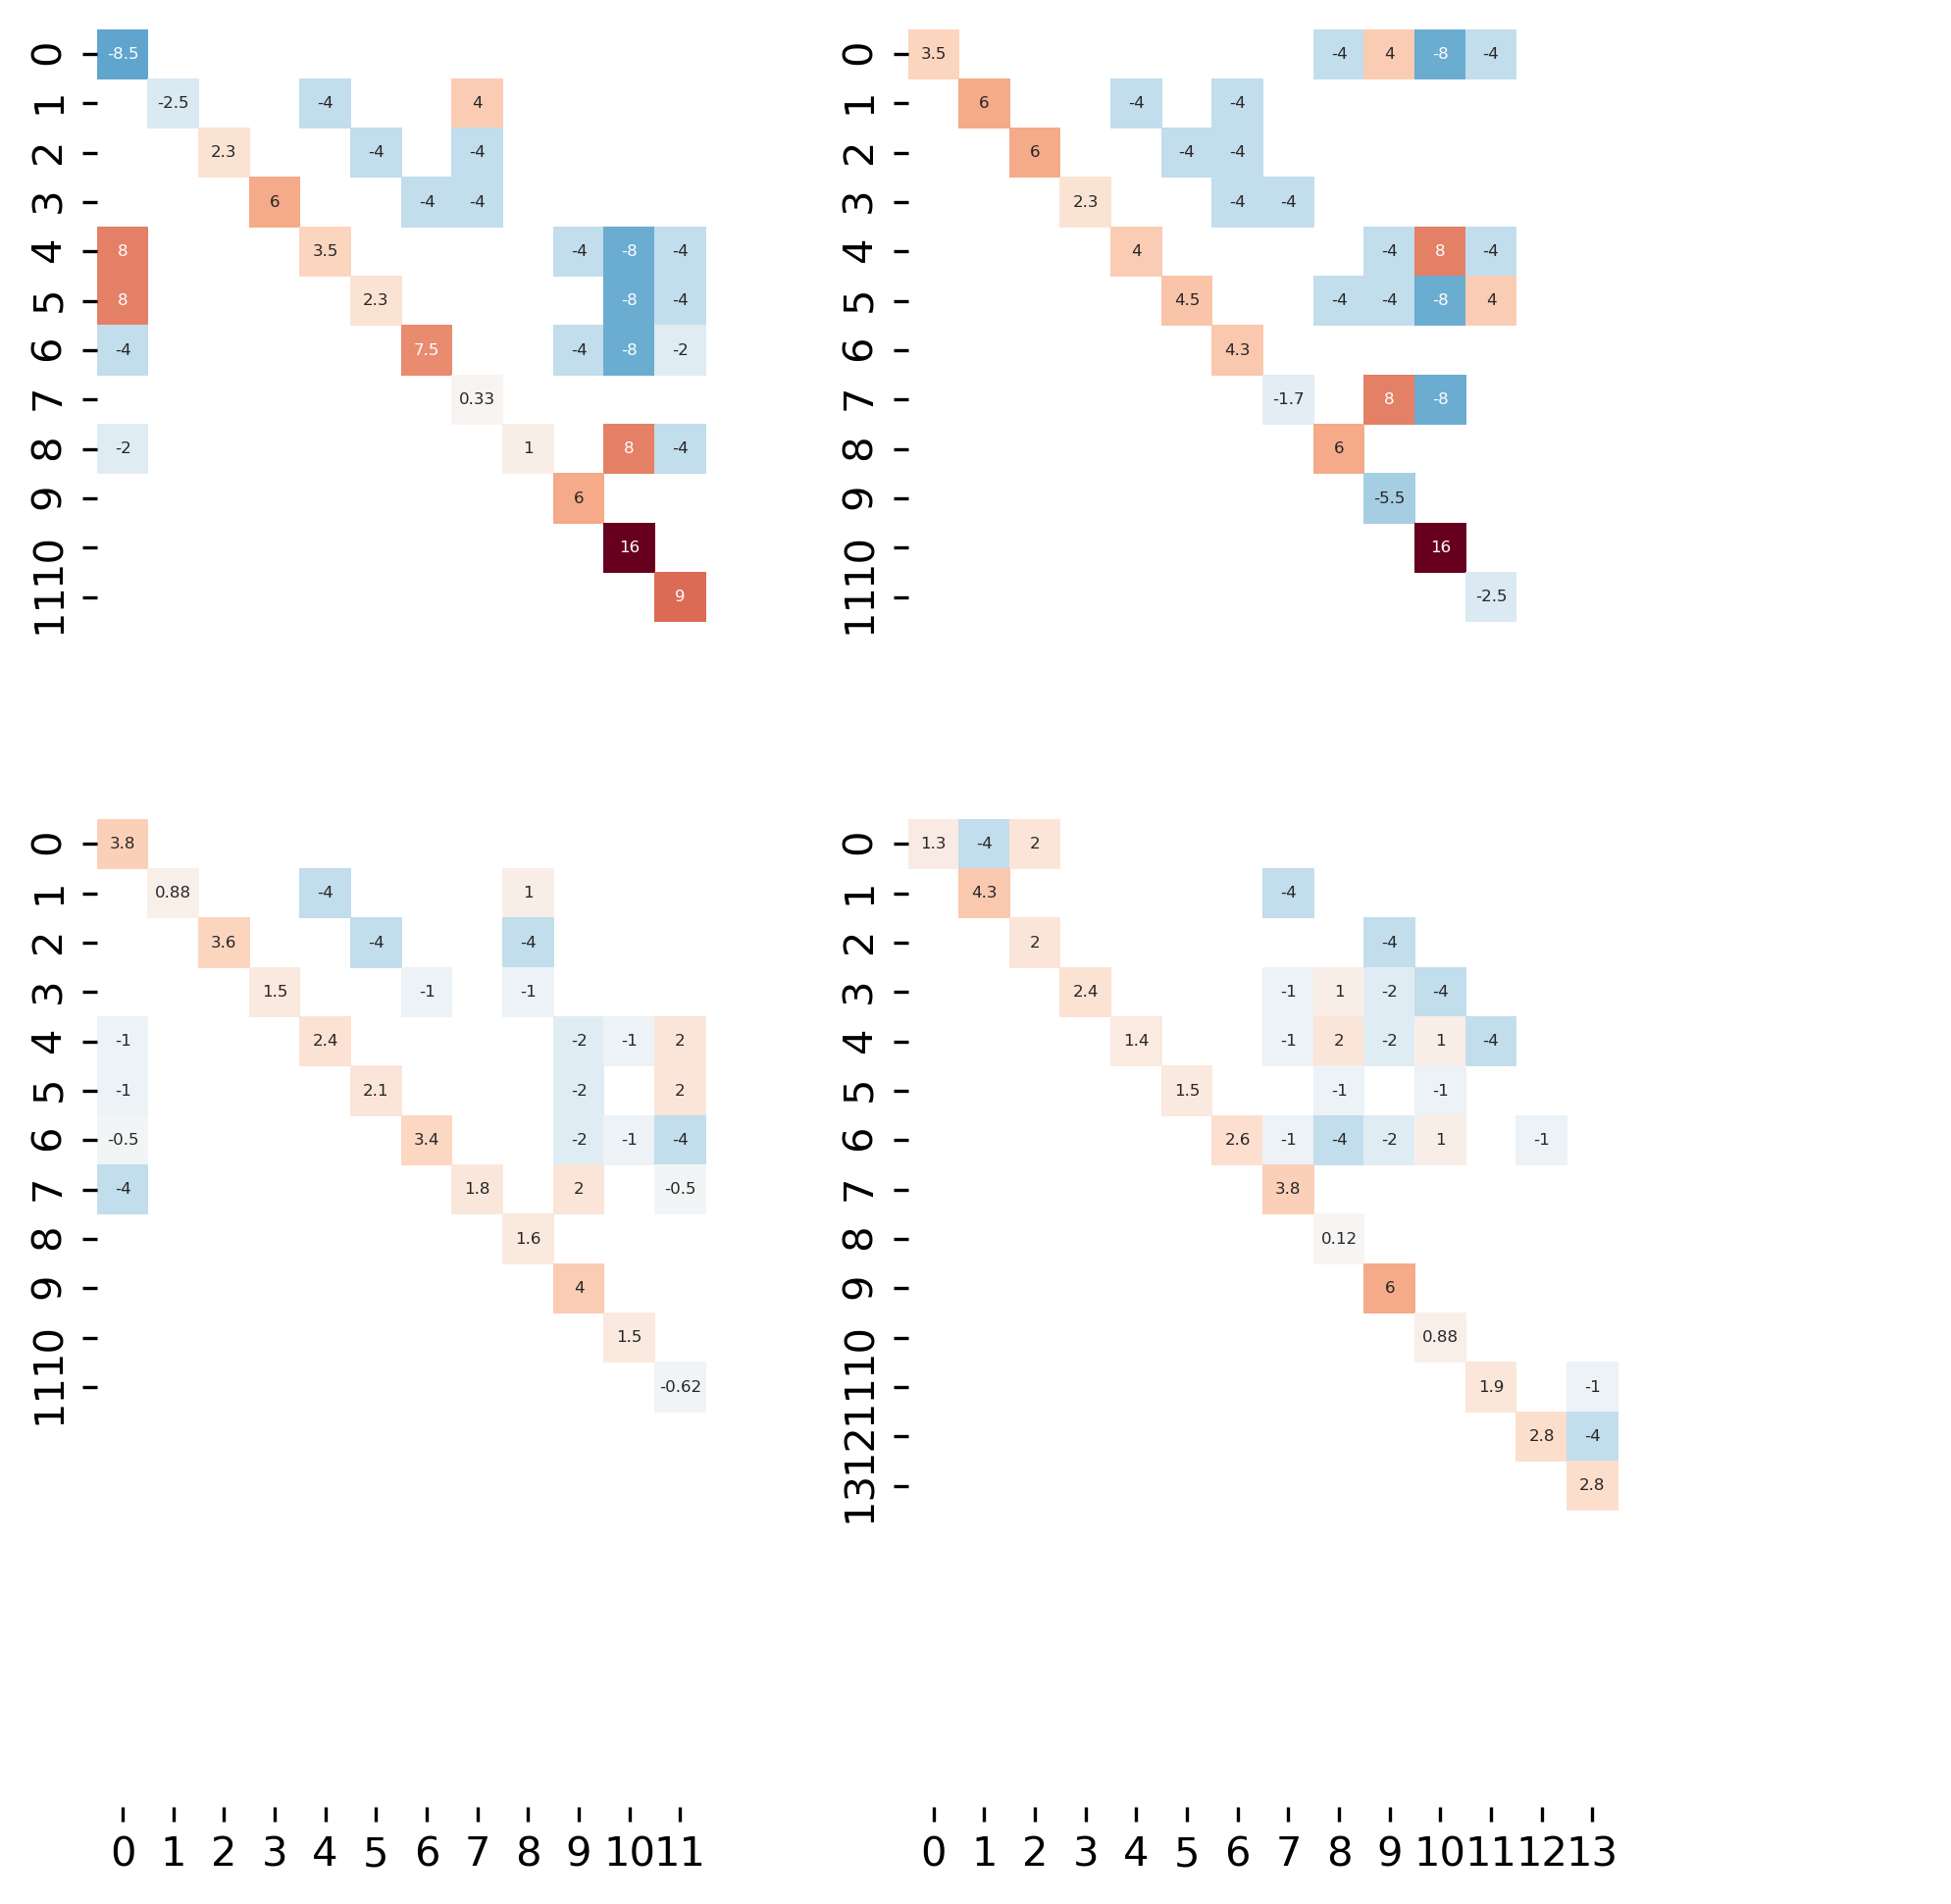

In [13]:
fig, axs = plt.subplots(figsize=(8, 8), dpi=300, ncols=2, nrows=2)

m = sucks(a1)
J, h, C = QUBO_to_Ising(m)
print(f"max(J) = {max(abs(J).flatten())}")
print(f"max(h) = {max(abs(h))}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges")

vmax = np.abs(m).max()

ax = axs.flatten()[0]
sns.heatmap(
    m,
    annot=True,
    ax=ax,
    annot_kws={"fontsize": 4},
    cmap="RdBu_r",
    vmin=-vmax,
    vmax=vmax,
    mask=m == 0,
    cbar=False,
)

ax.set_xlim(0, 20)
ax.set_ylim(20, 0)

m = sucks(a2)
J, h, C = QUBO_to_Ising(m)
print(f"max(J) = {max(abs(J).flatten())}")
print(f"max(h) = {max(abs(h))}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges")

ax = axs.flatten()[1]
sns.heatmap(
    m,
    annot=True,
    ax=ax,
    annot_kws={"fontsize": 4},
    cmap="RdBu_r",
    vmin=-vmax,
    vmax=vmax,
    mask=m == 0,
    cbar=False,
)

ax.set_xlim(0, 20)
ax.set_ylim(20, 0)

m = sucks(a3)
J, h, C = QUBO_to_Ising(m)
print(f"max(J) = {max(abs(J).flatten())}")
print(f"max(h) = {max(abs(h))}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges")

ax = axs.flatten()[2]
sns.heatmap(
    m,
    annot=True,
    ax=ax,
    annot_kws={"fontsize": 4},
    cmap="RdBu_r",
    vmin=-vmax,
    vmax=vmax,
    mask=m == 0,
    cbar=False,
)

ax.set_xlim(0, 20)
ax.set_ylim(20, 0)

m = sucks(a4)
J, h, C = QUBO_to_Ising(m)
print(f"max(J) = {max(abs(J).flatten())}")
print(f"max(h) = {max(abs(h))}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges")

ax = axs.flatten()[3]
sns.heatmap(
    m,
    annot=True,
    ax=ax,
    annot_kws={"fontsize": 4},
    cmap="RdBu_r",
    vmin=-vmax,
    vmax=vmax,
    mask=m == 0,
    cbar=False,
)

ax.set_xlim(0, 20)
ax.set_ylim(20, 0)

plt.subplots_adjust(wspace=-0.2, hspace=-0.2)
plt.show()

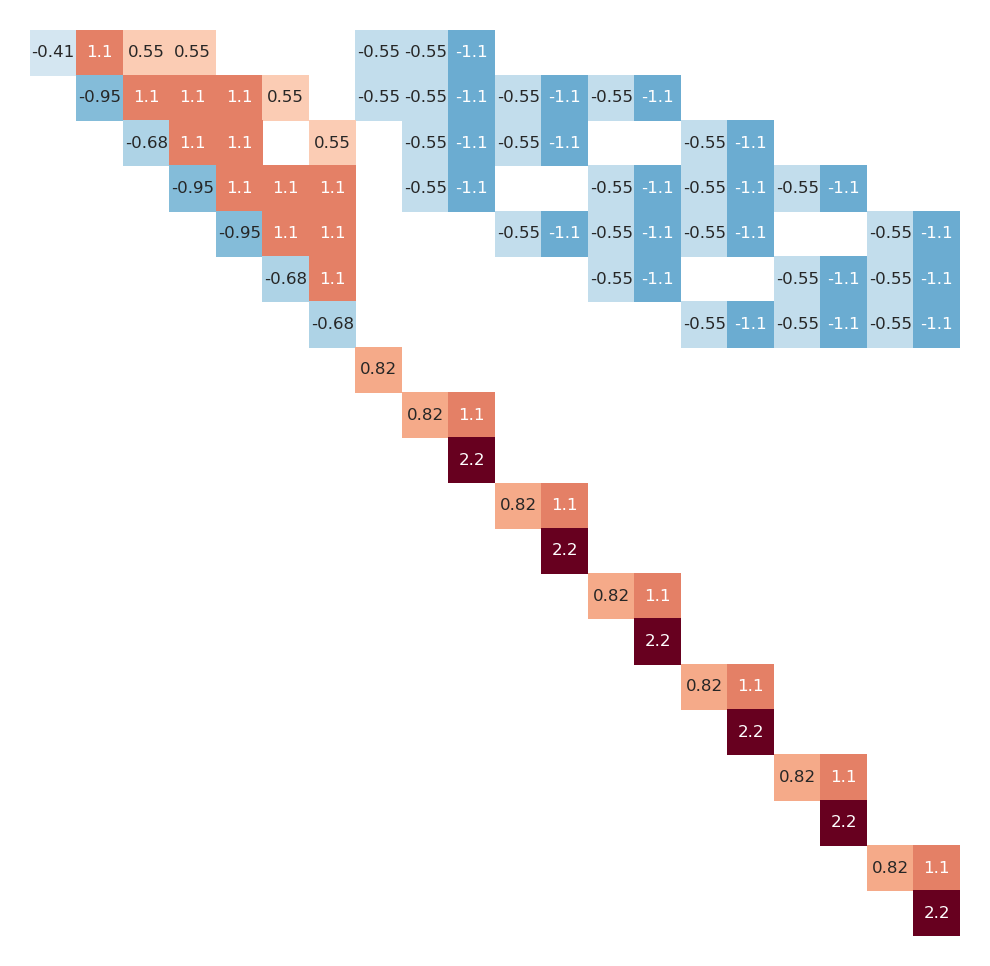

In [14]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

m = qubo.todense()
vmax = np.abs(m).max()

sns.heatmap(
    m,
    annot=True,
    ax=ax,
    annot_kws={"fontsize": 4},
    cmap="RdBu_r",
    vmin=-vmax,
    vmax=vmax,
    mask=m == 0,
    cbar=False,
)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0, 20)
ax.set_ylim(20, 0)

plt.show()

In [15]:
m = sucks(a5)
J, h, C = QUBO_to_Ising(m)
print(f"max(J) = {max(abs(J).flatten())}")
print(f"max(h) = {max(abs(h))}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges")

max(J) = 1.0
max(h) = 1.0
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges
